In [1]:
#Libraries from Demo
import os
import shutil
from collections import defaultdict

import pandas as pd
import polars as pl
import pydicom as dicom


#Libraries from attempt
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import Counter
from scipy import ndimage

from scipy.ndimage import zoom as ndi_zoom
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader, Subset
from typing import Tuple, List


from sklearn.preprocessing import StandardScaler

In [2]:
ID_COL = 'SeriesInstanceUID'

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN_CSV = "/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv"
test_frac = 0.2
val_frac = 0.1
val_frac_within_trainval = val_frac / (1 - test_frac)
seed = 42  

In [4]:
LABEL_COLS = [
    'Left Infraclinoid Internal Carotid Artery',
    'Right Infraclinoid Internal Carotid Artery',
    'Left Supraclinoid Internal Carotid Artery',
    'Right Supraclinoid Internal Carotid Artery',
    'Left Middle Cerebral Artery',
    'Right Middle Cerebral Artery',
    'Anterior Communicating Artery',
    'Left Anterior Cerebral Artery',
    'Right Anterior Cerebral Artery',
    'Left Posterior Communicating Artery',
    'Right Posterior Communicating Artery',
    'Basilar Tip',
    'Other Posterior Circulation',
    'Aneurysm Present',
]

In [5]:
train = pd.read_csv(TRAIN_CSV)
print(f"On the original Dataset, the percentage of aneurysms is: {100 * sum(train['Aneurysm Present'])/len(train)}%")
print(f"The original dataset has {len(train)} samples.")

On the original Dataset, the percentage of aneurysms is: 42.84728610855566%
The original dataset has 4348 samples.


In [6]:
excluded = np.load('/kaggle/input/succesful/usefull.npz')["lst"]
print(len(excluded))
train = train[train['SeriesInstanceUID'].isin(excluded)]

3984


In [7]:
y = train["Aneurysm Present"].astype(int).values
sss = StratifiedShuffleSplit(n_splits=1, test_size=test_frac, random_state=seed)
(trainval_idx, test_idx), = sss.split(np.zeros(len(y)), y)
y_trainval = y[trainval_idx]

sss_2 = StratifiedShuffleSplit(n_splits=1, test_size=val_frac_within_trainval, random_state=seed)
(train_rel_idx, val_rel_idx), = sss_2.split(np.zeros(len(y_trainval)), y_trainval)
train_idx = trainval_idx[train_rel_idx]
val_idx   = trainval_idx[val_rel_idx]

train_ds = Subset(train, train_idx.tolist())
val_ds   = Subset(train, val_idx.tolist())
test_ds  = Subset(train, test_idx.tolist())

print(f"Train/Val/Test sizes: {len(train_ds)} / {len(val_ds)} / {len(test_ds)}")
print(len(train.iloc[train_idx]), len(train.iloc[val_idx]), len(train.iloc[test_idx]))
print("Train positive rate:", train.iloc[train_idx]["Aneurysm Present"].mean())
print("Val   positive rate:", train.iloc[val_idx]["Aneurysm Present"].mean())
print("Test   positive rate:", train.iloc[test_idx]["Aneurysm Present"].mean())

Train/Val/Test sizes: 2788 / 399 / 797
2788 399 797
Train positive rate: 0.37625538020086086
Val   positive rate: 0.37593984962406013
Test   positive rate: 0.37641154328732745


# Helper Function

In [8]:
def build_roi_from_pred_mask(vol_tensor, mask_logits, padding=5, size=(64,64,64)):
    probs = torch.sigmoid(mask_logits)
    mask  = (probs > 0.5).float()  # [1,1,D,H,W]

    # Fallback: center crop if empty mask
    if mask.sum() == 0:
        _,_,D,H,W = vol_tensor.shape
        Dz,Dy,Dx = size
        cz,cy,cx = D//2, H//2, W//2
        z_min = max(0, cz - Dz//2); z_max = min(D, z_min + Dz)
        y_min = max(0, cy - Dy//2); y_max = min(H, y_min + Dy)
        x_min = max(0, cx - Dx//2); x_max = min(W, x_min + Dx)
        crop = vol_tensor[:, :, z_min:z_max, y_min:y_max, x_min:x_max]
        return F.interpolate(crop, size=size, mode='trilinear', align_corners=False)

    idx = mask.nonzero(as_tuple=False)  # [N,5] (B,C,D,H,W)
    d_min = max(0, idx[:,2].min().item() - padding)
    d_max = idx[:,2].max().item() + padding + 1
    h_min = max(0, idx[:,3].min().item() - padding)
    h_max = idx[:,3].max().item() + padding + 1
    w_min = max(0, idx[:,4].min().item() - padding)
    w_max = idx[:,4].max().item() + padding + 1

    _,_,D,H,W = vol_tensor.shape
    d_max = min(D, d_max)
    h_max = min(H, h_max)
    w_max = min(W, w_max)

    crop = vol_tensor[:, :, d_min:d_max, h_min:h_max, w_min:w_max]
    roi  = F.interpolate(crop, size=size, mode='trilinear', align_corners=False)
    return roi

# Datasets

In [9]:
from torch.utils.data import Dataset
from pathlib import Path
import os, numpy as np, torch

from torch.utils.data import Dataset
import os, numpy as np, torch

class CachedROIDataset(Dataset):
    def __init__(self, df, id_col, label_cols, transform=None):
        # Get the classification label from the dataframe
        self.base_dataset = df
        self.label_cols = label_cols 
        self.df = df.reset_index(drop=True).copy()
        self.id_col = id_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # GGet sid to get the roi
        sid = str(self.df[self.id_col].iloc[idx])

        # Get the classification label from the dataframe
        labels = self.df[self.label_cols].iloc[idx].values
        labels = labels.astype(np.float32)

        rois_path = '/kaggle/input/u-net-generated-rois/generated_rois/'
        roi_path = rois_path + sid + '.npz'

        # Load files
        roi  = np.load(roi_path)["vol"].astype(np.float32)      # [1, 1, D, H, W]


        # Convert to PyTorch tensors with channel dimension
        roi = torch.from_numpy(roi)    # [1, 1, D, H, W]
        return roi[0], torch.from_numpy(labels)

    def verify(self):
        missing = []
        for sid in self.df[self.id_col].astype(str):
            if self._find_files(sid) is None:
                missing.append(sid)
        return missing


In [10]:
train_ds = CachedROIDataset(
    df=train.iloc[train_idx],
    id_col=ID_COL,
    label_cols=LABEL_COLS,
)

valid_ds = CachedROIDataset(
    df=train.iloc[val_idx],
    id_col=ID_COL,
    label_cols=LABEL_COLS,
)

test_ds = CachedROIDataset(
    df=train.iloc[test_idx],
    id_col=ID_COL,
    label_cols=LABEL_COLS,
)
print(len(train_ds), len(valid_ds), len(test_ds))

2788 399 797


# Reviewing X=volume, Y=mask

Volume: torch.Size([1, 64, 64, 64])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


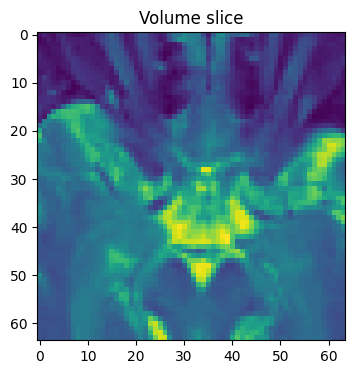

In [11]:
x, y = train_ds[2]
print("Volume:", x.shape)

plt.figure(figsize=(10,4))
plt.imshow(x[0, 32].numpy())
plt.title("Volume slice")

print(y)

# Model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math
from functools import partial

class AneurysmClassifier3D(nn.Module):
    def __init__(self, in_channels=1, num_classes=14):
        super().__init__()
        
        # A simple stack of Conv3D -> BN -> ReLU -> MaxPool
        self.features = nn.Sequential(
            self._conv_block(in_channels, 16),
            nn.MaxPool3d(2), # 64 -> 32
            
            self._conv_block(16, 32),
            nn.MaxPool3d(2), # 32 -> 16
            
            self._conv_block(32, 64),
            nn.MaxPool3d(2), # 16 -> 8
            
            self._conv_block(64, 128),
            nn.MaxPool3d(2), # 8 -> 4
        )
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool3d(1), # Flattens [128, 4, 4, 4] -> [128, 1, 1, 1]
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def _conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Training

## AUC

In [13]:
def auc_metrics(model, loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for img, labels in loader:
            img = img.to(device)
            probs = torch.sigmoid(model(img))
            all_probs.append(probs.cpu())
            all_labels.append(labels)

    all_probs = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()
    auc = roc_auc_score(all_labels[:, -1], all_probs[:, -1])
    print(f"Aneurysm Present AUC: {auc:.4f}")
    return auc

## Training Loop

In [14]:
def train_roi_classifier(
    num_epochs=10,
    batch_size=8, # We can use larger batches now because crops are smaller (64^3)
    lr=1e-3,
    wd=1e-3,
    save_path='aneurysm_roi_classifier_3DCNN.pth',
    device=DEVICE):
    
    train_ds = CachedROIDataset(df=train.iloc[train_idx],
                                id_col=ID_COL,
                                label_cols=LABEL_COLS,)

    valid_ds = CachedROIDataset(df=train.iloc[val_idx],
                                id_col=ID_COL,
                                label_cols=LABEL_COLS,)

    test_ds = CachedROIDataset(df=train.iloc[test_idx],
                                id_col=ID_COL,
                                label_cols=LABEL_COLS,)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    model = AneurysmClassifier3D(num_classes=len(LABEL_COLS)).to(device)

    train_labels_df = train.iloc[train_idx][LABEL_COLS]
    label_means = train_labels_df.mean().values 

    pos_weight_np = (1.0 - label_means) / (label_means)
    max_weight = 10.0
    pos_weight_np = np.clip(pos_weight_np, 1.0, max_weight)
    pos_weight = torch.tensor(pos_weight_np, dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    
    best_auc = 0.0
    print("Starting ROI Classification Training...")
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * imgs.size(0)
            
            # Accuracy calc
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.numel() 

        epoch_loss = train_loss / len(train_ds)

        # --- Validation ---
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.numel()
        
        val_epoch_loss = val_loss / len(valid_ds)
        val_auc = auc_metrics(model, val_loader, device)
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f}| "
              f"Val Loss: {val_epoch_loss:.4f} AUC: {val_auc:.4f}")
        
        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), save_path)
            print('Best AUC so far saved to: ', save_path)

    return model

In [15]:
classifier_model = train_roi_classifier(
    num_epochs=30,
    batch_size=8,
    lr=1e-4,
    save_path='aneurysm_roi_classifier_3DCNN.pth',
    device=DEVICE)

Starting ROI Classification Training...
Aneurysm Present AUC: 0.6188
Epoch 1/30 | Train Loss: 0.7933| Val Loss: 0.6930 AUC: 0.6188
Best AUC so far saved to:  aneurysm_roi_classifier_3DCNN.pth
Aneurysm Present AUC: 0.5920
Epoch 2/30 | Train Loss: 0.7398| Val Loss: 0.6636 AUC: 0.5920
Aneurysm Present AUC: 0.6064
Epoch 3/30 | Train Loss: 0.7272| Val Loss: 0.6539 AUC: 0.6064
Aneurysm Present AUC: 0.6123
Epoch 4/30 | Train Loss: 0.7176| Val Loss: 0.6669 AUC: 0.6123
Aneurysm Present AUC: 0.6360
Epoch 5/30 | Train Loss: 0.7194| Val Loss: 0.6443 AUC: 0.6360
Best AUC so far saved to:  aneurysm_roi_classifier_3DCNN.pth
Aneurysm Present AUC: 0.6258
Epoch 6/30 | Train Loss: 0.7094| Val Loss: 0.6500 AUC: 0.6258
Aneurysm Present AUC: 0.6389
Epoch 7/30 | Train Loss: 0.7039| Val Loss: 0.6360 AUC: 0.6389
Best AUC so far saved to:  aneurysm_roi_classifier_3DCNN.pth
Aneurysm Present AUC: 0.6357
Epoch 8/30 | Train Loss: 0.6981| Val Loss: 0.6345 AUC: 0.6357
Aneurysm Present AUC: 0.6371
Epoch 9/30 | Train L